# Heavy Equipment Case Study: Data Munging

The goal of this case study is to **predict the sale price of a particular piece of heavy equipment** at auction based on it's usage, equipment type, and configuration. The data is sourced from auction result postings and includes information on usage and equipment configurations.

### Exploratory Data Analysis (EDA)

In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_validation import cross_val_score, KFold, train_test_split
import seaborn as sns
%matplotlib inline

In [155]:
# Since we know that saledate should be treated as datetime, let's parse it as we load the data in.
df = pd.read_csv('data/Train.csv', parse_dates=['saledate'])

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401125 entries, 0 to 401124
Data columns (total 53 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null int64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null object
saledate                    401125 non-null datetime64[ns]
fiModelDesc                 401125 non-null object
fiBaseModel                 401125 non-null object
fiSecondaryDesc             263934 non-null object
fiModelSeries               56908 non-null object
fiModelDescriptor           71919 non-null object
ProductSize                 190350 non-null object
fiProductClassDesc          401125 non-null object
state                

After loading in the csv to a Pandas DataFrame object, we observe that there are 53 columns. The column SalePrice looks like our target variable. We have 52 potential features to work with - that's quite a lot, and there are a LOT of missing values, so we'll probably have to do:

- drop columns if there are too many missing values, or if multi-collinearity exists
- convert incorrect data types
- perform some scaled operation (log transform and/or standard-scale everything)
- feature engineer new columns
- impute missing values

## Examining our target variable (SalePrice)

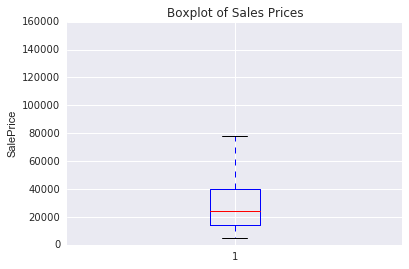

In [113]:
_=plt.boxplot(df['SalePrice'])
plt.title('Boxplot of Sales Prices')
plt.ylabel('SalePrice')

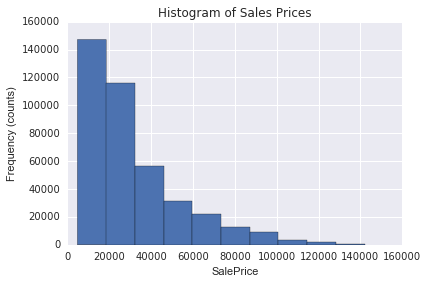

In [114]:
df['SalePrice'].hist()
plt.title('Histogram of Sales Prices')
plt.xlabel('SalePrice')
plt.ylabel('Frequency (counts)')

SalePrice data looks pretty right-skewed. If we log-transform it will behave more like a normal distribution.

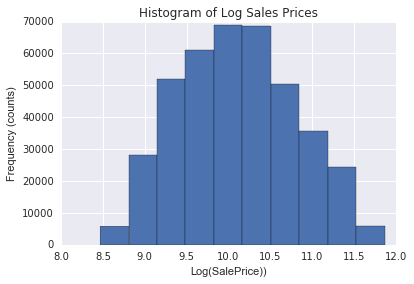

In [115]:
np.log(df['SalePrice']).hist()
plt.title('Histogram of Log Sales Prices')
plt.xlabel('Log(SalePrice))')
plt.ylabel('Frequency (counts)')

This looks more Gaussian now, despite the kurtosis being a little smaller than we'd like. We could model our data to the log price, but we'd have to remember to transform it back afterwards. Let's leave it as is for now.

## Exploring the Data

Before we do any data exploration, let's create a separate DataFrame containing just those columns that we have complete data for.

In [97]:
col_counts = df.apply(lambda x: x.count(), axis=0)
keep_columns = col_counts[col_counts == col_counts.max()]
dense = df.ix[:,keep_columns.index]

In [100]:
dense.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401125 entries, 0 to 401124
Data columns (total 13 columns):
SalesID               401125 non-null int64
SalePrice             401125 non-null int64
MachineID             401125 non-null int64
ModelID               401125 non-null int64
datasource            401125 non-null int64
YearMade              401125 non-null int64
saledate              401125 non-null datetime64[ns]
fiModelDesc           401125 non-null object
fiBaseModel           401125 non-null object
fiProductClassDesc    401125 non-null object
state                 401125 non-null object
ProductGroup          401125 non-null object
ProductGroupDesc      401125 non-null object
dtypes: datetime64[ns](1), int64(6), object(6)
memory usage: 42.8+ MB


First things first, let's convert the ID columns into strings, since they should not be treated as ints/floats.

In [158]:
id_cols = ['SalesID', 'MachineID', 'ModelID']
dense[id_cols] = dense[id_cols].astype('str', inplace=True)

In [159]:
dense.describe()

,SalePrice,datasource,YearMade
count,401125.000000,401125.000000,401125.000000
mean,31099.712848,134.665810,1899.156901
std,23036.898502,8.962237,291.797469
min,4750.000000,121.000000,1000.000000
25%,14500.000000,132.000000,1985.000000
50%,24000.000000,132.000000,1995.000000
75%,40000.000000,136.000000,2000.000000
max,142000.000000,172.000000,2013.000000


### YearSold

Looking at the statistics summary table above, it looks like the minimum YearMade is 1000. This is clearly an erroneous value so let's take a look at what we should do with them.

In [128]:
dense['YearMade'].value_counts()[:10]

1000    38185
1998    21221
2005    20587
2004    20020
1997    18905
1999    18767
2000    16742
1996    16691
1995    15528
1994    14199
Name: YearMade, dtype: int64

There are 38,185 entries with YearMade=1000. That's about 10% of our data, so we shouldn't just drop it. An initial hypothesis could be that these are typos for '2000'. Let's check.

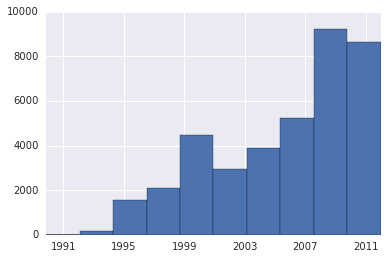

In [133]:
dense[dense['YearMade']==1000]['saledate'].hist()

A sizeable chunk of these were sold before the year 2000, negates our hypothesis. Let's replace these values with some central tendency metric.

In [151]:
print 'Mean:', dense[dense['YearMade']>1000]['YearMade'].mean()
print 'Median:', dense[dense['YearMade']>1000]['YearMade'].median()
print 'Mode:', dense[dense['YearMade']>1000]['YearMade'].mode()[0]

Mean: 1993.75740343
Median: 1996.0
Mode: 1998


Since the range for saledate is 1989-2013, let's use the mode. (This is a relatively arbitrary decision- it could have been any.)

In [161]:
dense['YearMade'] = dense['YearMade'].apply(lambda x: 1998 if x==1000 else x)

Note that some will still have a 'negative age', since a handful of these have yearsold < 1998. In fact, the age of a machine is probably quite important to its selling price! One would think that an older machine would sell for less than a newer machine. Let's feature-engineer a new column for that.

### Age of Machine

In [167]:
dense['Age'] = dense['saledate'].dt.year - dense['YearMade']

In [169]:
dense['Age'].describe()

count    401125.000000
mean          9.934452
std           7.397564
min         -12.000000
25%           5.000000
50%           8.000000
75%          13.000000
max          92.000000
Name: Age, dtype: float64

Let's fix the negative age problem by setting them to the average age (of all positives).

In [172]:
dense[dense['Age']>=0]['Age'].mean()

10.024990017554037

In [173]:
dense['Age'] = dense['Age'].apply(lambda x: 10 if x<0 else x)

### Dealing with the ID columns

Some thoughts about the ID columns:
- SalesID is unlikely to provide us much insight, since it is the unique identifier to each sale.
- MachineID may be useful - a machine that's been sold 10+ times will probably have a lower price than something similar that's been resold only once.
- ModelID could also be useful - it probably groups machines by model, so we might be able to find price similarities for machines of the same model.

Let's do quick check.

In [176]:
for col in ['SalesID', 'MachineID', 'ModelID']:
    print dense[col].value_counts()[:5]
    print 'Unique items: ', len(dense[col].unique())
    print '\n'

1821187    1
2241093    1
1526110    1
1582977    1
1582976    1
Name: SalesID, dtype: int64
Unique items:  401125


2283592    26
2285830    25
1942724    23
1896854    22
2296335    20
Name: MachineID, dtype: int64
Unique items:  341027


4605    5039
3538    4869
3170    4315
4604    4233
3362    4083
Name: ModelID, dtype: int64
Unique items:  5218




We were correct about SalesID- let's drop it now.

In [256]:
dense.drop('SalesID', axis=1, inplace=True)

Let's now look at MachineID's distribution to see if it's worth further investigation.

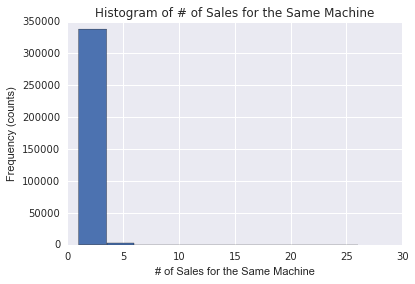

In [178]:
dense['MachineID'].value_counts().hist()
plt.title('Histogram of # of Sales for the Same Machine')
plt.xlabel('# of Sales for the Same Machine')
plt.ylabel('Frequency (counts)')

In [182]:
dense['MachineID'].value_counts().describe()

count    341027.000000
mean          1.176227
std           0.554880
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          26.000000
Name: MachineID, dtype: float64

The vast majority of the sales are for machines sold for their first time, so we are unlikely to get much insight from this. We can safely drop all three ID columns.

In [255]:
dense.drop('MachineID', axis=1, inplace=True)

Let's now take a look at ModelID.

In [180]:
dense['ModelID'].value_counts().describe()

count    5218.000000
mean       76.873323
std       264.912971
min         1.000000
25%         2.000000
50%         9.000000
75%        40.000000
max      5039.000000
Name: ModelID, dtype: float64

At least 75% of our data belongs to a ModelID that has been sold at least twice, so we might be able to use the mean of recent sales (for a given modelID) to predict future sales of that model. For the remaining < 25% of the data that we do not have similar historical sales data, we would have to ignore this aspect and use a simpler model. Let's pop this column out and see if we can revisit it later.

In [258]:
modelID = dense.pop('ModelID')

### Investigating Categorical Variables

In [196]:
# Printing all potential categorical variables
for col in dense.columns:
    print '{}: {} unique values'.format(col, len(dense[col].unique()))

SalesID 401125
SalePrice 899
MachineID 341027
ModelID 5218
datasource 5
YearMade 71
saledate 3919
fiModelDesc 4999
fiBaseModel 1950
fiProductClassDesc 74
state 53
ProductGroup 6
ProductGroupDesc 6
Age 80


fiModelDesc, fiBaseModel, and fiProductClassDesc are not numerical and have too many unique values to be coherent categorical variables. We could perform clustering, PCA, or use other matrix factorization techniques to find similarities within them but let's drop them for this model.

In [252]:
for x in ['fiModelDesc', 'fiBaseModel', 'fiProductClassDesc']:
    dense.drop(x, axis=1, inplace=True)

datasource, ProductGroup, and ProductGroupDesc look like potential candidates for being categorical variables in our model. Let's look at each of them.

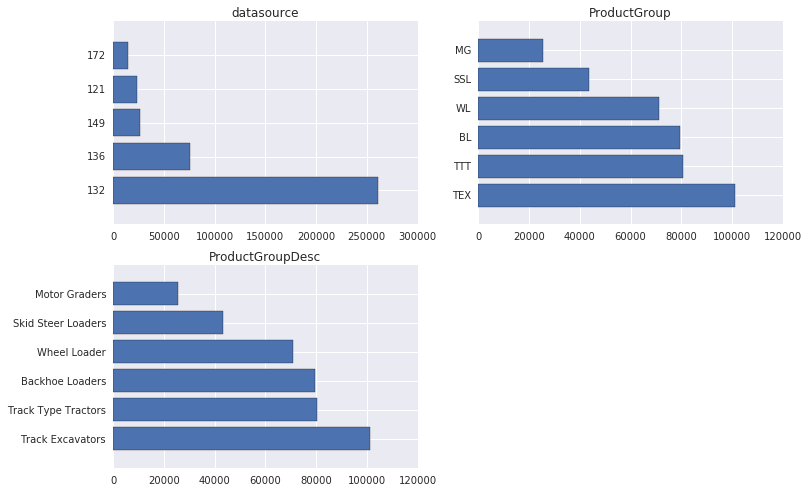

In [216]:
fig = plt.figure(figsize=(12,8))
for i,x in enumerate(['datasource', 'ProductGroup', 'ProductGroupDesc']):
    fig.add_subplot(2,2,i+1)
    plt.title(x)
    plt.barh(xrange(len(dense[x].value_counts())), dense[x].value_counts().values,
            tick_label = dense[x].value_counts().index, align='center')

Two quick observations here:
- ProductGroup and ProductGroupDesc are giving us the exact same information here. To avoid multi-collinearity, we should drop one of them. Let's keep ProductGroup since the labels are shorter/cleaner.
- Based on intuition, we hypothesize that datasource is unlikely to give us valuable info. The only reason it might is if the datasources are biased to begin with, e.g. if one datasource is just for luxury machines. Let's do a quick ttest to check if the prices in datasource=132 vary much from the rest.

In [245]:
prices_132 = dense[dense['datasource']==132]['SalePrice'].values
prices_not_132 = dense[dense['datasource']!=132]['SalePrice'].values
ttest_ind(prices_not_132, np.random.choice(prices_132, size=len(prices_not_132)))

Ttest_indResult(statistic=41.402631271298894, pvalue=0.0)

Since we're getting pretty significant results, let's use datasource but engineer a binary column out of it.

In [247]:
dense['datasource_132'] = dense['datasource'].apply(lambda x: True if x==132 else False)

Let's now create dummy columns for ProductGroup (but first drop ProductGroupDesc).

In [248]:
dense.drop('ProductGroupDesc', axis=1, inplace=True)

In [260]:
dense = pd.get_dummies(dense, columns=['ProductGroup'])

### Temporal Feature Engineering

One might hypothesize that there are seasonal factors (month of year) in the selling price of a machine. Others might even posit that there are patterns in the time of month, or the day of week. Let's create columns for these 3 temporal features. Obviously not all three will be important (maybe none of them!) - we can remove these later on in the modeling phase if that is what we discover.

In [351]:
dense['sale_month'] = dense['saledate'].dt.month
dense['sale_dayofmonth'] = dense['saledate'].dt.day
dense['sale_dayofweek'] = dense['saledate'].dt.dayofweek

### Geographical Feature Engineering

Another factor that might influence price is where it is sold. Converting all 52 (data says 53- we'll clean it up later) states into dummy variables add a lot of unnecessary dimensionality to our data. Let's bin them into the following regions grabbed from Google.

In [324]:
newengland = 'Connecticut, Maine, Massachusetts, New Hampshire, Rhode Island, Vermont'
midatlantic = 'Delaware, Maryland, New Jersey, New York, Pennsylvania, Washington DC'
south = 'Alabama, Arkansas, Florida, Georgia, Kentucky, Louisiana, Mississippi, Missouri, North Carolina, South Carolina, Tennessee, Virginia, West Virginia'
midwest = 'Illinois, Indiana, Iowa, Kansas, Michigan, Minnesota, Nebraska, North Dakota, Ohio, South Dakota, Wisconsin'
southwest = 'Arizona, New Mexico, Oklahoma, Texas'
west = 'Alaska, California, Colorado, Hawaii, Idaho, Montana, Nevada, Oregon, Utah, Washington, Wyoming'

In [325]:
region_names = ['newengland','midatlantic','south','midwest','southwest','west']
regions = [newengland, midatlantic, south, midwest, southwest, west]
regions_dict = {k: None for k in region_names}
for region,lst in zip(region_names, regions):
    regions_dict[region] = lst.split(', ')

In [326]:
def binStates(state):
    for name,lst in regions_dict.iteritems():
        if state in lst:
            return name
    return state

In [332]:
dense['region'] = dense['state'].apply(binStates)
dense['region'].value_counts()

south          157028
west            73146
southwest       65695
midatlantic     42903
midwest         42859
newengland      16657
Unspecified      2801
Puerto Rico        36
Name: region, dtype: int64

After binning them, we see that 'Unspecified' and 'Puerto Rico' have not been properly binned. Let's assign them to either the mode (South) or their most similar price groups.

In [337]:
dense.pivot_table('SalePrice', 'region')

region
Puerto Rico    25847.222222
Unspecified    34857.711532
midatlantic    27892.110552
midwest        28184.574092
newengland     28042.024374
south          32622.377633
southwest      32764.612665
west           30480.047330
Name: SalePrice, dtype: float64

In [338]:
dense['region'] = dense['region'].apply(lambda x: 'south' if x=='Unspecified' else x)
dense['region'] = dense['region'].apply(lambda x: 'midatlantic' if x=='Puerto Rico' else x)

Now we're ready to create dummy variables.

In [340]:
dense = pd.get_dummies(dense, columns=['region'])

### Final Data Inspection

In [353]:
dense.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401125 entries, 0 to 401124
Data columns (total 22 columns):
SalePrice             401125 non-null int64
datasource            401125 non-null int64
YearMade              401125 non-null int64
saledate              401125 non-null datetime64[ns]
state                 401125 non-null object
Age                   401125 non-null int64
datasource_132        401125 non-null bool
ProductGroup_BL       401125 non-null float64
ProductGroup_MG       401125 non-null float64
ProductGroup_SSL      401125 non-null float64
ProductGroup_TEX      401125 non-null float64
ProductGroup_TTT      401125 non-null float64
ProductGroup_WL       401125 non-null float64
region_midatlantic    401125 non-null float64
region_midwest        401125 non-null float64
region_newengland     401125 non-null float64
region_south          401125 non-null float64
region_southwest      401125 non-null float64
region_west           401125 non-null float64
sale_month          

We can drop the following columns:
- datasource (we created a new binary column datasource_132)
- saledate (we feature-engineered several columns out of that)
- state (we feature-engineered 'region' out of that)
- YearMade (we used that and saledate to create 'Age')

In [354]:
dense.drop(['datasource', 'saledate', 'state', 'YearMade'], axis=1, inplace=True)

### Visualizing Feature Relationships / Multi-Collinearity

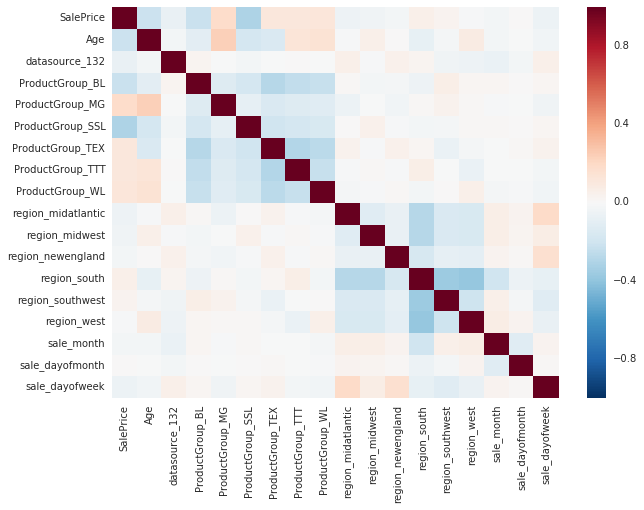

In [358]:
correlations = dense.corr()
plt.figure(figsize=(10,7))
sns.heatmap(correlations)

In [359]:
correlations

,SalePrice,Age,datasource_132,ProductGroup_BL,ProductGroup_MG,ProductGroup_SSL,ProductGroup_TEX,ProductGroup_TTT,ProductGroup_WL,region_midatlantic,region_midwest,region_newengland,region_south,region_southwest,region_west,sale_month,sale_dayofmonth,sale_dayofweek
SalePrice,1.000000,-0.217569,-0.074181,-0.220037,0.182638,-0.311069,0.115117,0.110048,0.119882,-0.048235,-0.043768,-0.027627,0.055178,0.031984,-0.012703,-0.028498,0.000013,-0.056823
Age,-0.217569,1.000000,-0.026115,-0.108340,0.238560,-0.176400,-0.153358,0.128492,0.143945,-0.013623,0.057891,0.001152,-0.080403,-0.016598,0.081849,-0.023784,-0.005299,-0.037049
datasource_132,-0.074181,-0.026115,1.000000,0.027023,-0.006110,-0.023578,-0.000864,0.003312,-0.007593,0.054901,-0.014070,0.054655,0.024725,-0.044041,-0.050081,-0.064425,-0.029263,0.059798
ProductGroup_BL,-0.220037,-0.108340,0.027023,1.000000,-0.129423,-0.173254,-0.288541,-0.248992,-0.230505,0.010258,-0.028844,-0.018714,-0.047014,0.066704,0.020213,0.019462,0.000522,0.020310
ProductGroup_MG,0.182638,0.238560,-0.006110,-0.129423,1.000000,-0.090836,-0.151280,-0.130545,-0.120852,-0.057996,-0.005506,-0.038852,0.011144,0.044309,0.014319,-0.012250,-0.005746,-0.041760
ProductGroup_SSL,-0.311069,-0.176400,-0.023578,-0.173254,-0.090836,1.000000,-0.202513,-0.174755,-0.161780,0.005337,0.049796,-0.010284,-0.025728,-0.017406,0.010505,0.014922,0.003925,0.022661
ProductGroup_TEX,0.115117,-0.153358,-0.000864,-0.288541,-0.151280,-0.202513,1.000000,-0.291042,-0.269433,0.045387,-0.009224,0.052023,0.023027,-0.066745,-0.021066,-0.004862,0.009778,0.045590
ProductGroup_TTT,0.110048,0.128492,0.003312,-0.248992,-0.130545,-0.174755,-0.291042,1.000000,-0.232502,-0.010294,0.011095,-0.015182,0.063839,-0.007573,-0.066473,-0.001193,-0.001318,-0.030255
ProductGroup_WL,0.119882,0.143945,-0.007593,-0.230505,-0.120852,-0.161780,-0.269433,-0.232502,1.000000,-0.018824,-0.008076,0.009485,-0.030270,0.000111,0.054905,-0.017856,-0.009810,-0.033087
region_midatlantic,-0.048235,-0.013623,0.054901,0.010258,-0.057996,0.005337,0.045387,-0.010294,-0.018824,1.000000,-0.119754,-0.072068,-0.281789,-0.153228,-0.163510,0.063603,0.034223,0.191489


### Columns with Missing/Null Values

Before we pass our data in through a model, let's go back to our original dataframe (df), take a look at the columns with missing values and see if we can impute values for columns that are "almost" dense. We define this as having no more than 20% missing values (about 80,000 rows).

In [294]:
dfnulls = df.isnull()
for col in dfnulls:
    missing = sum(dfnulls[col])
    if missing < 80000 and missing > 0:
        print '{}: {} missing values'.format(col, missing)

auctioneerID: 20136 missing values
Enclosure: 325 missing values


#### AuctioneerID

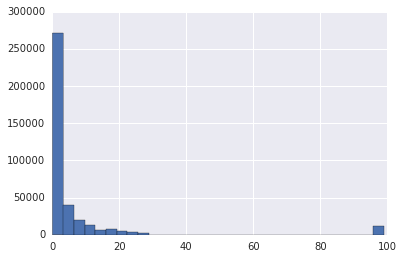

In [76]:
df['auctioneerID'].hist(bins=len(df['auctioneerID'].unique()))

The vast majority of sales are from auctioneerID = 1. Insight is unlikely to be derived from this variable.

#### Enclosure

In [382]:
df['Enclosure'].value_counts()

OROPS                  174257
EROPS                  139026
EROPS w AC              87820
EROPS AC                   17
NO ROPS                     3
None or Unspecified         2
Name: Enclosure, dtype: int64

Let's first combine 'EROPS w AC' with 'EROPS AC', then impute the missing 325 values, 'NO ROPS', and 'None or Unspecified' to be the mode ('OROPS').
Finally, we'll dummify them and concatenate to our dense dataframe.

In [377]:
df['Enclosure'].fillna(df['Enclosure'].mode()[0], inplace=True)

In [395]:
df['Enclosure'] = df['Enclosure'].apply(lambda x: 'EROPS w AC' if x=='EROPS AC' else x)
df['Enclosure'] = df['Enclosure'].apply(lambda x: df['Enclosure'].mode()[0] if x=='NO ROPS' else x)
df['Enclosure'] = df['Enclosure'].apply(lambda x: df['Enclosure'].mode()[0] if x=='None or Unspecified' else x)

In [396]:
df['Enclosure'].value_counts()

OROPS         174262
EROPS         139026
EROPS w AC     87837
Name: Enclosure, dtype: int64

In [399]:
dense = pd.concat((dense,pd.get_dummies(df['Enclosure'])), axis=1)

## Exporting the Data

Now we're ready to do the modeling - let's export it to another csv.

In [402]:
dense.to_csv('/Users/MikeYung/Galvanize/regression-case-study/data/train_cleaned.csv')